In [2]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator, AudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
import math
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.utils import plot_model
# from Heartnet import heartnet,getAttentionModel
from collections import Counter
from torchviz import make_dot
def to_numpy(x):
    return x.cpu().detach().numpy()
def plotf(x):
    plt.plot(to_numpy(x))

In [3]:
# from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
# import seaborn as sns
# import Evaluator
import dataLoader
# from custom_layers import Attention
from sklearn.model_selection import train_test_split

In [4]:
class wow():
    def __init__(self):
        self.dann = False
        self.self = False
        self.reduce = None
        self.shuffle = 1
        self.mfcc = False
args = wow()

In [5]:
test_domains = 'a'
train_domains = 'cdebf'
source_domain = train_domains
target_domain = test_domains

test_split = 0
fold_dir = '../data/all_folds_wav_name/'

if(args.self):
    print("Self training activated")
    x_train, y_train, y_domain, train_parts, x_val, y_val, val_domain, val_parts,val_wav_files = dataLoader.getData(fold_dir,'',test_domains,0.9,shuffle=args.shuffle)
    print(x_train.shape, x_val.shape)
else:
    x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split,shuffle = args.shuffle)

if(args.reduce):
    print("Reduction ", args.reduce)
    x_train,_,y_train,_,y_domain,_ = train_test_split(x_train.transpose(),y_train,y_domain,stratify=y_train,test_size = args.reduce)
    x_train = x_train.transpose()

    #x_val,_,y_val,_,val_domain,_ = train_test_split(x_val.transpose(),y_val,val_domain,stratify=y_val,test_size = args.reduce)
    #x_val = x_val.transpose()

val_files = val_domain
#Create meta labels and domain labels

if(test_split>0):
    source_domain = "".join(set(source_domain).union(set(target_domain)))
    #domains = domains + test_domains

if(args.self):
    print("self training")
    source_domain = test_domains

domains = set(source_domain + target_domain)
#num_class_domain = len(set(train_domains + test_domains))
num_class_domain = len(domains)
num_class = 2

domainClass_source = [(cls,dfc) for cls in range(2) for dfc in source_domain]
domainClass_target = [(cls,dfc) for cls in range(2) for dfc in target_domain]

Train normal -  60862 - 6466  Abnormal
                90  -  9 %
Test normal -  4303 - 9864  Abnormal
               30  -  69 %


# Load old fold0_noFIR.mat

In [3]:
import h5py
path = '../data/fold0_noFIR.mat'
data = h5py.File(path, 'r')

In [4]:
list(data.keys())

['trainX',
 'trainY',
 'train_files',
 'train_parts',
 'valX',
 'valY',
 'val_files',
 'val_parts']

In [5]:
x_train = data['trainX'][:].astype('float32')
x_train = np.expand_dims(x_train.transpose(),1)

In [6]:
x_val = data['valX'][:].astype('float32')
x_val = np.expand_dims(x_val.transpose(),1)

In [7]:
y_train = data['trainY'][:].astype('int32')
y_train = y_train.transpose()
y_train = y_train[:,0]
y_train[y_train<0] = 0

In [8]:
y_val = data['valY'][:].astype('int32')
y_val = y_val.transpose()
y_val = y_val[:,0]
y_val[y_val<0] = 0

In [9]:
val_parts = data['val_parts'][:].astype('int32').squeeze(0)
val_files = data['val_files'][:].astype('int32').squeeze(0)
train_files = data['train_files'][:].astype('int32').squeeze(0)

In [10]:
domains = list(Counter(train_files).keys())
domainClass = [(cls,dfc) for cls in range(2) for dfc in domains]
meta_labels = [domainClass.index((cl,df)) for (cl,df) in zip((y_train),train_files)]

# mfcc extraction

In [ ]:
## Convert to MFCC
import python_speech_features as psf
from matplotlib import cm
if(args.mfcc):
    train_mfcc = np.array([(psf.base.mfcc(x,samplerate=1000,winlen=0.05,winstep=0.01)) for x in x_train.transpose()])
    val_mfcc = np.array([(psf.base.mfcc(x,samplerate=1000,winlen=0.05,winstep=0.01)) for x in x_val.transpose()])
    
    train_mfcc = (train_mfcc-np.mean(train_mfcc))/np.std(train_mfcc)
    val_mfcc = (val_mfcc-np.mean(val_mfcc))/np.std(val_mfcc)
    #train_mfcc = train_mfcc/np.max(np.abs(train_mfcc))
    #val_mfcc = val_mfcc/np.max(np.abs(val_mfcc))
    
    del x_train, x_val
    x_train = train_mfcc.copy()
    x_val = val_mfcc.copy()
    print(x_train.shape, x_val.shape)

In [6]:
meta_labels_source = [domainClass_source.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]
meta_labels_target = None
if(args.dann):
    meta_labels_target = [domainClass_target.index((cl,df)) for (cl,df) in zip((y_val),(val_domain))]
    

domains = "".join(set(source_domain).union(set(target_domain)))

y_domain_source = np.array([list(domains).index(lab) for lab in y_domain])

y_domain_target = np.array([list(domains).index(lab) for lab in val_domain])

################### Reshaping ############

if(args.mfcc):
    [], [y_train,y_domain,y_val] = reshape_folds([],[y_train,y_domain_source,y_val])
else:
    [x_train,x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain_source,y_val])
y_train = to_categorical(y_train, num_classes=num_class)

print("Y domain ", Counter([x[0] for x in y_domain]))
print("Val domain ", Counter(val_domain))
print("Source Meta labels ", Counter(meta_labels_source))
print("Target Meta labels ", Counter(meta_labels_target))
y_domain_source = to_categorical(y_domain_source,num_classes=num_class_domain)

y_val = to_categorical(y_val, num_classes=num_class)
y_domain_target = to_categorical(y_domain_target,num_classes=num_class_domain)


val_domain = y_domain_target
print("Train files ", y_train.shape, "  Domain ", y_domain.shape)
print("Test files ", y_val.shape, "  Domain ", val_domain.shape)

### Batch Size limmiter 
batch_size = 1000
if(batch_size > max(y_train.shape)):
    print("Batch size if given greater than train files size. limiting batch size")
    batch_size = max(y_train.shape)

reshaped x  (67328, 2500, 1)
reshaped x  (14167, 2500, 1)
reshaped Y  (67328, 1)
reshaped Y  (67328, 1)
reshaped Y  (14167, 1)
Y domain  Counter({3: 57642, 2: 4119, 5: 2985, 1: 1781, 4: 801})
Val domain  Counter({'a': 14167})
Source Meta labels  Counter({2: 54790, 4: 3012, 7: 2852, 3: 2396, 5: 1425, 9: 1107, 8: 589, 6: 493, 0: 356, 1: 308})
Target Meta labels  Counter()
Train files  (67328, 2)   Domain  (67328, 1)
Test files  (14167, 2)   Domain  (14167, 6)


In [7]:
x_train.shape,x_val.shape, y_train.shape, y_val.shape, y_domain.shape,val_domain.shape,Counter(meta_labels_source),Counter(meta_labels_target)

((67328, 2500, 1),
 (14167, 2500, 1),
 (67328, 2),
 (14167, 2),
 (67328, 1),
 (14167, 6),
 Counter({5: 1425,
          0: 356,
          1: 308,
          6: 493,
          2: 54790,
          7: 2852,
          3: 2396,
          8: 589,
          4: 3012,
          9: 1107}),
 Counter())

In [8]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
y_train = np.argmax(y_train,1)

In [10]:
y_val = np.argmax(y_val,1)

In [11]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((67328, 1, 2500), (67328,), (14167, 1, 2500), (14167,))

In [7]:
######## change 2500 axis for pytorch 
x_train = x_train.transpose((0,2,1))
x_val = x_val.transpose((0,2,1))

In [8]:
x_train.shape,y_train.shape

((67328, 1, 2500), (67328, 2))

In [18]:
x_train = x_train[:2100,:,:]
y_train = y_train[:20000]

In [13]:
meta_labels = meta_labels_source

In [14]:
batch_size = 24
datagen_source = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
flow_source = datagen_source.flow(x_train, y_train,
                meta_label=meta_labels,
                batch_size=batch_size, shuffle=True,
                seed=1)
# datagen_source_balanced = AudioDataGenerator(shift=.1,data_format = 'channels_first')
# flow_source = datagen_source_balanced.flow(x_train, y_train,
#                 batch_size=batch_size, shuffle=True,
#                 seed=1)
# datagen_val = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
# flow_val = datagen_val.flow(x_val, y_val,
#                 meta_label=y_val,
#                 batch_size=batch_size, shuffle=True,
#                 seed=1)
try:
    flow_source.steps_per_epoch = len(flow_source)
except:
    pass

[  356   308 54790  2396  3012  1425   493  2852   589  1107]
[0 1 2 3 4 5 6 7 8 9]
Chunk size selected as 2


/media/mhealthra2/Data/heart_sound/Adversarial-Heart-Sound-Classification/codes/BalancedDannAudioDataGenerator.py:841: UserWarning: `meta_labels` specified, will use meta_labels instead of target_label
  warnings.warn('`meta_labels` specified, will use meta_labels instead of target_label')


In [56]:
x,y = flow_source.next()
x,y = torch.from_numpy(x),torch.from_numpy(y)
x = x.type(torch.FloatTensor).cuda()
holdx = x
print(x.shape)
x = mfcc_gen(x)
x.shape

torch.Size([24, 1, 2500])


torch.Size([24, 1, 64, 240])

In [57]:

hold = x
x = x.transpose(2,1)
x = x.unsqueeze(1)
print(x.shape)

torch.Size([24, 1, 64, 1, 240])


In [15]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np

In [16]:
import HeartCepTorch,importlib
HeartCepTorch = importlib.reload(HeartCepTorch)
from HeartCepTorch import MFCC_Gen,Network,MFCC_Gen_coeff

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torchsummary import summary

In [17]:
from torch.nn.parameter import Parameter
from HeartCepTorch import Conv_Gammatone_coeff
class Branch(nn.Module):
    def __init__(self,c_in, c_out, kernel_size=5,stride=1,dropout = 0.5):
        super(Branch, self).__init__()
        self.conv1 = nn.Conv1d(c_in, c_out*2, kernel_size=kernel_size,stride=stride)
        self.bn1 = nn.BatchNorm1d(c_out*2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(c_out*2, c_out, kernel_size=kernel_size,stride=stride)
        self.bn2 = nn.BatchNorm1d(c_out)
        self.pool = nn.MaxPool1d(2)
    def forward(self, x):
        x = self.drop(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(x)
        x = self.drop(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(x)
        return x
class Net(nn.Module):
    def __init__(self,filters=64,kernel_size=81,fs=1000):
        super(Net,self).__init__()
        wow = Conv_Gammatone_coeff(1,filters,kernel_size,fs)
        self.filterbank = nn.ModuleList()
        for i in range(filters):
            conv = nn.Conv1d(1,1,kernel_size=kernel_size)
            conv.weight = Parameter(wow.weight[i:i+1])
            self.filterbank.append(conv)
        self.branches = nn.ModuleList()
        for i in range(filters):
            branch = Branch(1,4)
            self.branches.append(branch)
        self.dense = nn.Linear(4*602*filters,20)
        self.cls = nn.Linear(20,2)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax()
    def forward(self,x):
        x = [c(x) for c in self.filterbank]
        x = [c(xx) for (xx,c) in zip(x,self.branches)]
        x = torch.cat(x,dim=1)
        x = x.view(x.size(0),-1)
        x = self.relu(self.dense(x))
        x = self.soft(self.cls(x))
        return x
model = Net()

In [28]:
model = Network(2,0)
mfcc_gen = MFCC_Gen_coeff(fs=1000,filters=64,momentum=0.1)

In [45]:
mfcc_gen.gamma.weight = Parameter(torch.from_numpy(bank))

In [19]:
path = '/media/mhealthra2/Data/heart_sound/Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 HNET_2020-05-17 17.56.06.569274/weights/'
weights = os.listdir(path)
wow = dict(torch.load(path+weights[53]))
gamma_weight = torch.cat([wow['filterbank.{}.weight'.format(i)] for i in range(64)])  

In [21]:
from torch.nn.parameter import Parameter
mfcc_gen.gamma.weight = Parameter(gamma_weight)

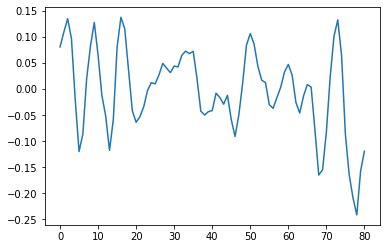

In [25]:
plt.plot(to_numpy(mfcc_gen.gamma.weight[35]).squeeze())

In [41]:
summary(model.cuda(),(1,240,64))

OK
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 244, 65]             128
       BatchNorm2d-2          [-1, 16, 244, 65]              48
            Conv2d-3          [-1, 32, 242, 63]           4,672
       BatchNorm2d-4          [-1, 32, 242, 63]              96
         Dropout2d-5          [-1, 32, 242, 63]               0
            Conv2d-6          [-1, 32, 244, 65]           9,280
       BatchNorm2d-7          [-1, 32, 244, 65]              96
         Dropout2d-8          [-1, 32, 244, 65]               0
            Conv2d-9          [-1, 64, 122, 32]          18,560
      BatchNorm2d-10          [-1, 64, 122, 32]             192
        Dropout2d-11          [-1, 64, 122, 32]               0
           Conv2d-12           [-1, 64, 61, 16]          36,992
      BatchNorm2d-13           [-1, 64, 61, 16]             192
        Dropout2d-14           [-1, 

In [37]:
summary(mfcc_gen.cuda(),(1,2500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    Conv_Gammatone-1             [-1, 64, 2420]             192
       BatchNorm1d-2             [-1, 64, 2420]             192
            Conv1d-3              [-1, 64, 240]         102,400
       BatchNorm2d-4           [-1, 1, 64, 240]               3
Total params: 102,787
Trainable params: 195
Non-trainable params: 102,592
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.60
Params size (MB): 0.39
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


In [66]:
class WHOLE_MODEL(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1):
        super(WHOLE_MODEL,self).__init__()
        self.mfcc = MFCC_Gen_coeff(fs=1000,filters=64,momentum=0.99)
        self.classifier = Network(2,0)
        for x in self.mfcc.gamma.named_parameters():
            x[1].requires_grad = False
    def forward(self,x):
        x = self.mfcc(x)
#         mfcc = x
        x = x.unsqueeze(1)
        x = x.transpose(3,2)
        x = self.classifier(x)
        return x#,mfcc

In [67]:
model = WHOLE_MODEL()

In [44]:
model.mfcc.gamma.weight.shape

torch.Size([64, 1, 81])

In [68]:
summary(model.cuda(),(1,2500))

OK
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2420]           5,312
       BatchNorm1d-2             [-1, 64, 2420]             192
            Conv1d-3              [-1, 64, 240]         102,400
       BatchNorm1d-4              [-1, 64, 240]             192
    MFCC_Gen_coeff-5              [-1, 64, 240]         107,906
            Conv2d-6          [-1, 16, 244, 65]             128
       BatchNorm2d-7          [-1, 16, 244, 65]              48
            Conv2d-8          [-1, 32, 242, 63]           4,672
       BatchNorm2d-9          [-1, 32, 242, 63]              96
        Dropout2d-10          [-1, 32, 242, 63]               0
           Conv2d-11          [-1, 32, 244, 65]           9,280
      BatchNorm2d-12          [-1, 32, 244, 65]              96
        Dropout2d-13          [-1, 32, 244, 65]               0
           Conv2d-14          [-1, 6

In [29]:
optimizer = optim.SGD(model.parameters(), lr= .00001)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()
# class_criterion = nn.BCELoss()
start_epoch = 0
lr_schedule = optim.lr_scheduler.ExponentialLR(optimizer,1)
# wow= []
# for i in range(400):
#     optimizer.step()
#     wow.append(optimizer.param_groups[0]['lr'])
#     sh.step()
# plt.plot(wow)
# print(wow[-1])

In [53]:
summary(model.cuda(),(1,240,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 244, 65]             128
       BatchNorm2d-2          [-1, 16, 244, 65]              48
            Conv2d-3          [-1, 32, 242, 63]           4,672
       BatchNorm2d-4          [-1, 32, 242, 63]              96
         Dropout2d-5          [-1, 32, 242, 63]               0
            Conv2d-6          [-1, 32, 244, 65]           9,280
       BatchNorm2d-7          [-1, 32, 244, 65]              96
         Dropout2d-8          [-1, 32, 244, 65]               0
            Conv2d-9          [-1, 64, 122, 32]          18,560
      BatchNorm2d-10          [-1, 64, 122, 32]             192
        Dropout2d-11          [-1, 64, 122, 32]               0
           Conv2d-12           [-1, 64, 61, 16]          36,992
      BatchNorm2d-13           [-1, 64, 61, 16]             192
        Dropout2d-14           [-1, 64,

In [ ]:
out = model(torch.randn(1,1,240,64))
make_dot(out,params = dict(model.named_parameters()))

In [20]:
from sklearn.metrics import confusion_matrix
eps = 0.0000001
def log_macc(y_pred, y_val,val_parts):
    y_pred = y_pred.cpu().detach().numpy()
#     y_pred_domain = y_pred_domain.cpu().detach().numpy()
    y_val = y_val.cpu().detach().numpy()
    true = []
    pred = []
    files = []
    start_idx = 0

#     y_pred = np.argmax(y_pred, axis=-1)
#     y_val = np.transpose(np.argmax(y_val, axis=-1))

    for j,s in enumerate(val_parts):

        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
        
        temp_ = y_val[start_idx:start_idx + int(s)]
        temp = y_pred[start_idx:start_idx + int(s)]

        if (sum(temp == 0) > sum(temp == 1)):
            pred.append(0)
        else:
            pred.append(1)

        if (sum(temp_ == 0) > sum(temp_ == 1)):
            true.append(0)
        else:
            true.append(1)

#         if val_files is not None:
#             files.append(val_files[start_idx])

        start_idx = start_idx + int(s)
    TN, FP, FN, TP = confusion_matrix(true, pred, labels=[0,1]).ravel()
    # TN = float(TN)
    # TP = float(TP)
    # FP = float(FP)
    # FN = float(FN)
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision,end=' ')
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)
    return Macc,sensitivity,specificity,precision,F1
def trainLog(y_true,y_pred):
    eps = 0.0000001
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision,end=' ')
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)
    

In [30]:
import importlib
from datetime import datetime
import CSVLogger
CSVLogger = importlib.reload(CSVLogger)
from CSVLogger import CSVLogger
fold = "a_bcdef 64 mfcc .00001"
path = "../../Heartnet_Results/logs/gammatone_torch_layer/"
fold = fold+'_'+str(datetime.now()).replace(':','.')
path = path + fold
if not os.path.isdir(path):
    os.mkdir(path)
    os.mkdir(os.path.join(path,'weights'))
logger = CSVLogger(path+'/'+'training.csv')
checkpoint_name = os.path.join(path,'weights') + "/" + 'weights.{epoch:04d}-acc_{val_acc:.4f}-macc_{macc:.4f}.pt'

# gradient accu

In [ ]:

###   MFCC

model.cuda()
mfcc_gen.cuda()
mfcc_gen.eval()
epochs = 1500
# torch.save(model,os.path.join(path,'model.pt'))
logger.on_train_begin()
print("steps ", flow_source.steps_per_epoch)

# with open(path+fold+'/model1.json', 'w') as outfile:
#     outfile.write(str(mod))
for e in range(epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    acc = 0
    y_pred = None
    y_true = None
    N = 0
    
    optimizer.zero_grad()
    for i in range(flow_source.steps_per_epoch+1):
        
        
        x,y = flow_source.next()
        if(str(class_criterion) in ['MSELoss()','BCELoss()']):
            y = to_categorical(y,2)
            y = y.astype(np.float32)
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        holdx = x
        x = mfcc_gen(x)
#         if(len(x)>1):
#             x = x[0]
        hold = x
        x = x.transpose(2,1)
        x = x.unsqueeze(1)
        # print(x.shape)
        x,y = Variable(x),Variable(y)
        
#         y = y.cuda()
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        loss = class_criterion(cls,y)
        loss.backward()
        epoch_loss = epoch_loss + loss
        if(i%50==0 or i==flow_source.steps_per_epoch):            
            optimizer.step()
            optimizer.zero_grad()
        
        
#         if(str(class_criterion)in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
    
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
    epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss
    acc_print = (acc.item()) if (type(acc)==torch.Tensor) else acc
    print("Training loss", "%.2f"%(epoch_loss_print/flow_source.steps_per_epoch),end=' ')
    print("Training Acc ", "%.2f"%(acc_print/N),end=' ')
    trainLog(y_true,y_pred)
    logger.logs['train_loss'] = (epoch_loss_print/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc_print/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = to_categorical(y,2)
                y = y.astype(np.float32)
            
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            holdvalx = x
            x = mfcc_gen(x)
#             if(len(x)>1):
#                 x = x[0]
            holdval = x
            x = x.transpose(2,1)
            x = x.unsqueeze(1)
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            cls= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
    lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

steps  27395
EPOCH    1
learning rate  1e-05


In [22]:
### HEartnet

epochs = 1500
# torch.save(model,os.path.join(path,'model.pt'))
logger.on_train_begin()
print("steps ", flow_source.steps_per_epoch)

# with open(path+fold+'/model1.json', 'w') as outfile:
#     outfile.write(str(mod))
for e in range(epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    acc = 0
    y_pred = None
    y_true = None
    N = 0
    
    optimizer.zero_grad()
    for i in range(flow_source.steps_per_epoch+1):
        
        
        x,y = flow_source.next()
        if(str(class_criterion) in ['MSELoss()','BCELoss()']):
            y = to_categorical(y,2)
            y = y.astype(np.float32)
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        # print(x.shape)
        x,y = Variable(x),Variable(y)
        
#         y = y.cuda()
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        loss = class_criterion(cls,y)
        loss.backward()
        epoch_loss = epoch_loss + loss
        if(i%50==0 or i==flow_source.steps_per_epoch):            
            optimizer.step()
            optimizer.zero_grad()
        
        
#         if(str(class_criterion)in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
    
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
    epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss
    acc_print = (acc.item()) if (type(acc)==torch.Tensor) else acc
    print("Training loss", "%.2f"%(epoch_loss_print/flow_source.steps_per_epoch),end=' ')
    print("Training Acc ", "%.2f"%(acc_print/N),end=' ')
    trainLog(y_true,y_pred)
    logger.logs['train_loss'] = (epoch_loss_print/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc_print/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = to_categorical(y,2)
                y = y.astype(np.float32)
            
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            cls= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
    lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

steps  27673
EPOCH    1
learning rate  0.005


/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training loss 0.56 Training Acc  0.73 TN: 243233 FP: 88855 FN: 90757 TP: 241331
Sensitivity: 0.73 Specificity: 0.73 Precision: 0.73 F1: 0.73 MACC 0.73
TN: 117 FP: 29 FN: 47 TP: 91
Sensitivity: 0.66 Specificity: 0.80 Precision: 0.76 F1: 0.71 MACC 0.73
Validation loss 0.56 Validation Acc  0.72
EPOCH    2
learning rate  0.005
Training loss 0.49 Training Acc  0.82 TN: 269224 FP: 62864 FN: 58315 TP: 273773
Sensitivity: 0.82 Specificity: 0.81 Precision: 0.81 F1: 0.82 MACC 0.82
TN: 116 FP: 30 FN: 44 TP: 94
Sensitivity: 0.68 Specificity: 0.79 Precision: 0.76 F1: 0.72 MACC 0.74
Validation loss 0.55 Validation Acc  0.72
EPOCH    3
learning rate  0.005
Training loss 0.46 Training Acc  0.85 TN: 280975 FP: 51113 FN: 46194 TP: 285894
Sensitivity: 0.86 Specificity: 0.85 Precision: 0.85 F1: 0.85 MACC 0.85
TN: 114 FP: 32 FN: 40 TP: 98
Sensitivity: 0.71 Specificity: 0.78 Precision: 0.75 F1: 0.73 MACC 0.75
Validation loss 0.56 Validation Acc  0.71
EPOCH    4
learning rate  0.005
Training loss 0.44 Traini

TN: 126 FP: 20 FN: 50 TP: 88
Sensitivity: 0.64 Specificity: 0.86 Precision: 0.81 F1: 0.72 MACC 0.75
Validation loss 0.58 Validation Acc  0.72
EPOCH    27
learning rate  0.005
Training loss 0.35 Training Acc  0.96 TN: 318366 FP: 13722 FN: 12884 TP: 319204
Sensitivity: 0.96 Specificity: 0.96 Precision: 0.96 F1: 0.96 MACC 0.96
TN: 124 FP: 22 FN: 40 TP: 98
Sensitivity: 0.71 Specificity: 0.85 Precision: 0.82 F1: 0.76 MACC 0.78
Validation loss 0.56 Validation Acc  0.73
EPOCH    28
learning rate  0.005
Training loss 0.35 Training Acc  0.96 TN: 318695 FP: 13393 FN: 12906 TP: 319182
Sensitivity: 0.96 Specificity: 0.96 Precision: 0.96 F1: 0.96 MACC 0.96
TN: 126 FP: 20 FN: 38 TP: 100
Sensitivity: 0.72 Specificity: 0.86 Precision: 0.83 F1: 0.78 MACC 0.79
Validation loss 0.57 Validation Acc  0.73
EPOCH    29
learning rate  0.005
Training loss 0.35 Training Acc  0.96 TN: 318981 FP: 13107 FN: 12490 TP: 319598
Sensitivity: 0.96 Specificity: 0.96 Precision: 0.96 F1: 0.96 MACC 0.96
TN: 123 FP: 23 FN: 45

EPOCH    52
learning rate  0.005
Training loss 0.34 Training Acc  0.97 TN: 323182 FP: 8906 FN: 8420 TP: 323668
Sensitivity: 0.97 Specificity: 0.97 Precision: 0.97 F1: 0.97 MACC 0.97
TN: 123 FP: 23 FN: 33 TP: 105
Sensitivity: 0.76 Specificity: 0.84 Precision: 0.82 F1: 0.79 MACC 0.80
Validation loss 0.57 Validation Acc  0.72
EPOCH    53
learning rate  0.005
Training loss 0.34 Training Acc  0.97 TN: 323365 FP: 8723 FN: 8145 TP: 323943
Sensitivity: 0.98 Specificity: 0.97 Precision: 0.97 F1: 0.97 MACC 0.97
TN: 121 FP: 25 FN: 41 TP: 97
Sensitivity: 0.70 Specificity: 0.83 Precision: 0.80 F1: 0.75 MACC 0.77
Validation loss 0.58 Validation Acc  0.72
EPOCH    54
learning rate  0.005
Training loss 0.34 Training Acc  0.98 TN: 323406 FP: 8682 FN: 7874 TP: 324214
Sensitivity: 0.98 Specificity: 0.97 Precision: 0.97 F1: 0.98 MACC 0.98
TN: 120 FP: 26 FN: 29 TP: 109
Sensitivity: 0.79 Specificity: 0.82 Precision: 0.81 F1: 0.80 MACC 0.81
Validation loss 0.56 Validation Acc  0.73
EPOCH    55
learning rate 

TN: 120 FP: 26 FN: 38 TP: 100
Sensitivity: 0.72 Specificity: 0.82 Precision: 0.79 F1: 0.76 MACC 0.77
Validation loss 0.57 Validation Acc  0.73
EPOCH    78
learning rate  0.005
Training loss 0.33 Training Acc  0.98 TN: 325189 FP: 6899 FN: 6041 TP: 326047
Sensitivity: 0.98 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 113 FP: 33 FN: 31 TP: 107
Sensitivity: 0.78 Specificity: 0.77 Precision: 0.76 F1: 0.77 MACC 0.77
Validation loss 0.58 Validation Acc  0.72
EPOCH    79
learning rate  0.005
Training loss 0.33 Training Acc  0.98 TN: 325436 FP: 6652 FN: 6014 TP: 326074
Sensitivity: 0.98 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 121 FP: 25 FN: 42 TP: 96
Sensitivity: 0.70 Specificity: 0.83 Precision: 0.79 F1: 0.74 MACC 0.76
Validation loss 0.58 Validation Acc  0.73
EPOCH    80
learning rate  0.005
Training loss 0.33 Training Acc  0.98 TN: 325436 FP: 6652 FN: 6140 TP: 325948
Sensitivity: 0.98 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 128 FP: 18 FN: 44 TP: 

Training loss 0.33 Training Acc  0.98 TN: 326524 FP: 5564 FN: 5046 TP: 327042
Sensitivity: 0.98 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 117 FP: 29 FN: 35 TP: 103
Sensitivity: 0.75 Specificity: 0.80 Precision: 0.78 F1: 0.76 MACC 0.77
Validation loss 0.57 Validation Acc  0.73
EPOCH    104
learning rate  0.005
Training loss 0.33 Training Acc  0.98 TN: 326571 FP: 5517 FN: 4959 TP: 327129
Sensitivity: 0.99 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 117 FP: 29 FN: 40 TP: 98
Sensitivity: 0.71 Specificity: 0.80 Precision: 0.77 F1: 0.74 MACC 0.76
Validation loss 0.57 Validation Acc  0.73
EPOCH    105
learning rate  0.005
Training loss 0.33 Training Acc  0.98 TN: 326606 FP: 5482 FN: 4912 TP: 327176
Sensitivity: 0.99 Specificity: 0.98 Precision: 0.98 F1: 0.98 MACC 0.98
TN: 120 FP: 26 FN: 39 TP: 99
Sensitivity: 0.72 Specificity: 0.82 Precision: 0.79 F1: 0.75 MACC 0.77
Validation loss 0.57 Validation Acc  0.73
EPOCH    106
learning rate  0.005
Training loss 0.33 Train

TN: 120 FP: 26 FN: 45 TP: 93
Sensitivity: 0.67 Specificity: 0.82 Precision: 0.78 F1: 0.72 MACC 0.75
Validation loss 0.58 Validation Acc  0.72
EPOCH    129
learning rate  0.005
Training loss 0.33 Training Acc  0.99 TN: 327247 FP: 4841 FN: 4141 TP: 327947
Sensitivity: 0.99 Specificity: 0.99 Precision: 0.99 F1: 0.99 MACC 0.99
TN: 116 FP: 30 FN: 28 TP: 110
Sensitivity: 0.80 Specificity: 0.79 Precision: 0.79 F1: 0.79 MACC 0.80
Validation loss 0.56 Validation Acc  0.74
EPOCH    130
learning rate  0.005
Training loss 0.33 Training Acc  0.99 TN: 327131 FP: 4957 FN: 4210 TP: 327878
Sensitivity: 0.99 Specificity: 0.99 Precision: 0.99 F1: 0.99 MACC 0.99
TN: 118 FP: 28 FN: 34 TP: 104
Sensitivity: 0.75 Specificity: 0.81 Precision: 0.79 F1: 0.77 MACC 0.78
Validation loss 0.56 Validation Acc  0.73
EPOCH    131
learning rate  0.005
Training loss 0.33 Training Acc  0.99 TN: 327219 FP: 4869 FN: 4208 TP: 327880
Sensitivity: 0.99 Specificity: 0.99 Precision: 0.99 F1: 0.99 MACC 0.99
TN: 113 FP: 33 FN: 25 T

KeyboardInterrupt: 

In [32]:
bank = {i:to_numpy(model.filterbank[0].weight) for i in range(64)}

In [33]:
import pickle
with open("filterbank.pickle","wb") as f:
    pickle.dump(bank,f)

# Whole

In [25]:
model.cuda()
epochs = 400

logger
logger.on_train_begin()
optimizer.zero_grad()
print("steps ", flow_source.steps_per_epoch)
for e in range(start_epoch,epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    epoch_loss_list = []
    acc = 0
    N = 0
    for i in range(flow_source.steps_per_epoch+1):
        
        
        
        x,y = flow_source.next()
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        x,y = Variable(x),Variable(y)
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        class_loss = class_criterion(cls,y)
        loss = class_loss
        epoch_loss = epoch_loss + loss
        epoch_loss_list.append(loss)
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
        
        if(i%50==0 or i==flow_source.steps_per_epoch):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    print("Training loss", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    print("Training loss list", "%.2f"%(torch.mean(torch.tensor(epoch_loss_list)).item()),end=' ')
    print("Training Acc ", "%.2f"%(acc.item()/N))
    logger.logs['train_loss'] = (epoch_loss.item()/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc.item()/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            x,y = Variable(x),Variable(y)
            y = y.long().cuda()
            cls= model(x)
            val_class_loss = class_criterion(cls,y)
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
#     lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e) 
    flow_source.reset()
logger.on_train_end()

steps  32415
EPOCH    1
learning rate  0.005


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.91 GiB total capacity; 10.49 GiB already allocated; 17.56 MiB free; 11.02 GiB reserved in total by PyTorch)

# MFCC gen(not learning) -> Classfier(learning) two modules

In [ ]:
optimizer.param_groups[0]['lr']

In [21]:
path = '../../Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR batch1500 continued .005_2020-04-14 16.10.52.323265/weights/weights.0154-acc_0.7942-macc_0.8296.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [40]:
cls.shape, y.shape

(torch.Size([1, 2]), torch.Size([12]))

In [19]:
model.cuda()
mfcc_gen.cuda()
mfcc_gen.eval()
epochs = 400
# torch.save(model,os.path.join(path,'model.pt'))
logger.on_train_begin()
print("steps ", flow_source.steps_per_epoch)

# with open(path+fold+'/model1.json', 'w') as outfile:
#     outfile.write(str(mod))
for e in range(epochs):
    print("EPOCH   ",e+1)
    print("learning rate ",optimizer.param_groups[0]['lr'])
    model.train()
    epoch_loss = 0
    acc = 0
    y_pred = None
    y_true = None
    N = 0
    for i in range(flow_source.steps_per_epoch+1):
        optimizer.zero_grad()
        
        x,y = flow_source.next()
        if(str(class_criterion) in ['MSELoss()','BCELoss()']):
            y = to_categorical(y,2)
            y = y.astype(np.float32)
        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
        holdx = x
        x = mfcc_gen(x)
        if(len(x)>1):
            x = x[0]
        hold = x
        x = x.transpose(2,1)
        x = x.unsqueeze(1)
        # print(x.shape)
        x,y = Variable(x),Variable(y)
        
#         y = y.cuda()
        y = y.long().cuda()        
        cls = model(x)
        # class_loss = class_criterion(cls,torch.argmax(y,axis=1))        
        loss = class_criterion(cls,y)
        epoch_loss = epoch_loss + loss
        
        loss.backward()
        optimizer.step()
        
#         if(str(class_criterion)in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
    
        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
    print("Training loss", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    print("Training Acc ", "%.2f"%(acc.item()/N),end=' ')
    trainLog(y_true,y_pred)
    logger.logs['train_loss'] = (epoch_loss.item()/flow_source.steps_per_epoch)
    logger.logs['train_acc'] = (acc.item()/N)
    # Validate 
    model.eval()
    epoch_loss = 0
    acc = 0
    N = 0
    y_pred = None
    y_true = None
    with torch.no_grad():
        start_idx = 0
        for i,s in enumerate(val_parts):
            if(s==0):
                continue
            x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
            start_idx = start_idx+s
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = to_categorical(y,2)
                y = y.astype(np.float32)
            
            x,y = torch.from_numpy(x),torch.from_numpy(y)
            x = x.type(torch.FloatTensor).cuda()
            holdvalx = x
            x = mfcc_gen(x)
            if(len(x)>1):
                x = x[0]
            holdval = x
            x = x.transpose(2,1)
            x = x.unsqueeze(1)
            x,y = Variable(x),Variable(y)
            #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            
#             y = y.cuda()
            y = y.long().cuda()
            cls= model(x)
            # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
            val_class_loss = class_criterion(cls,y)
            
            if(str(class_criterion) in ['MSELoss()','BCELoss()']):
                y = torch.argmax(y,axis=1)
            
            acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
            N = N+len(y)
            epoch_loss = epoch_loss + val_class_loss
            if(y_pred is None):
                y_pred = torch.argmax(cls,axis=1)
                y_true = y
            else:
                y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
                y_true = torch.cat((y_true,y))
        Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
        print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
        print("Validation Acc ", "%.2f"%(acc.item()/N))
        logger.logs['val_loss'] = (epoch_loss.item()/len(val_parts))
        logger.logs['val_acc'] = (acc.item()/N)
        acc = (acc.item()/N)
        logger.logs['val_macc'] = Macc
        logger.logs['precision'] = precision
        logger.logs['sensitivity'] = sensitivity
        logger.logs['specificity'] = specificity
        logger.logs['F1'] = F1
    lr_schedule.step()
    torch.save(model.state_dict(),checkpoint_name.format(epoch=e,val_acc=acc,macc=Macc))
    logger.on_epoch_end(e)
    flow_source.reset()
logger.on_train_end()

steps  6483
EPOCH    1
learning rate  0.001
Training loss 0.61 Training Acc  0.68 TN: 44755 FP: 20085 FN: 21183 TP: 43657
Sensitivity: 0.67 Specificity: 0.69 Precision: 0.68 F1: 0.68 MACC 0.68
TN: 119 FP: 27 FN: 78 TP: 60
Sensitivity: 0.43 Specificity: 0.82 Precision: 0.69 F1: 0.53 MACC 0.62
Validation loss 0.62 Validation Acc  0.67
EPOCH    2
learning rate  0.00095
Training loss 0.54 Training Acc  0.77 TN: 48762 FP: 16078 FN: 14198 TP: 50642
Sensitivity: 0.78 Specificity: 0.75 Precision: 0.76 F1: 0.77 MACC 0.77
TN: 72 FP: 74 FN: 30 TP: 108
Sensitivity: 0.78 Specificity: 0.49 Precision: 0.59 F1: 0.67 MACC 0.64
Validation loss 0.60 Validation Acc  0.68
EPOCH    3
learning rate  0.0009025
Training loss 0.50 Training Acc  0.81 TN: 50005 FP: 14835 FN: 10196 TP: 54644
Sensitivity: 0.84 Specificity: 0.77 Precision: 0.79 F1: 0.81 MACC 0.81
TN: 66 FP: 80 FN: 20 TP: 118
Sensitivity: 0.86 Specificity: 0.45 Precision: 0.60 F1: 0.70 MACC 0.65
Validation loss 0.61 Validation Acc  0.68
EPOCH    4
le

TN: 66 FP: 80 FN: 3 TP: 135
Sensitivity: 0.98 Specificity: 0.45 Precision: 0.63 F1: 0.76 MACC 0.72
Validation loss 0.58 Validation Acc  0.73
EPOCH    26
learning rate  0.00027738957312183364
Training loss 0.43 Training Acc  0.88 TN: 53303 FP: 11537 FN: 4156 TP: 60684
Sensitivity: 0.94 Specificity: 0.82 Precision: 0.84 F1: 0.89 MACC 0.88
TN: 65 FP: 81 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.45 Precision: 0.63 F1: 0.77 MACC 0.72
Validation loss 0.59 Validation Acc  0.73
EPOCH    27
learning rate  0.0002635200944657419
Training loss 0.43 Training Acc  0.88 TN: 53423 FP: 11417 FN: 4070 TP: 60770
Sensitivity: 0.94 Specificity: 0.82 Precision: 0.84 F1: 0.89 MACC 0.88
TN: 65 FP: 81 FN: 3 TP: 135
Sensitivity: 0.98 Specificity: 0.45 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    28
learning rate  0.0002503440897424548
Training loss 0.43 Training Acc  0.88 TN: 53291 FP: 11549 FN: 3898 TP: 60942
Sensitivity: 0.94 Specificity: 0.82 Precision: 0.84 F1: 

Training loss 0.42 Training Acc  0.89 TN: 53720 FP: 11120 FN: 3623 TP: 61217
Sensitivity: 0.94 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    51
learning rate  7.69449752767131e-05
Training loss 0.42 Training Acc  0.89 TN: 53722 FP: 11118 FN: 3638 TP: 61202
Sensitivity: 0.94 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    52
learning rate  7.309772651287744e-05
Training loss 0.42 Training Acc  0.89 TN: 53651 FP: 11189 FN: 3622 TP: 61218
Sensitivity: 0.94 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    53
learning rate  6.9442840

TN: 60 FP: 86 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.41 Precision: 0.61 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    75
learning rate  2.2467088258818413e-05
Training loss 0.42 Training Acc  0.89 TN: 53791 FP: 11049 FN: 3555 TP: 61285
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    76
learning rate  2.134373384587749e-05
Training loss 0.42 Training Acc  0.89 TN: 53766 FP: 11074 FN: 3498 TP: 61342
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 60 FP: 86 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.41 Precision: 0.61 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    77
learning rate  2.0276547153583614e-05
Training loss 0.42 Training Acc  0.89 TN: 53762 FP: 11078 FN: 3450 TP: 61390
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1:

Training loss 0.42 Training Acc  0.89 TN: 53733 FP: 11107 FN: 3456 TP: 61384
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    100
learning rate  6.232136021404205e-06
Training loss 0.42 Training Acc  0.89 TN: 53842 FP: 10998 FN: 3462 TP: 61378
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    101
learning rate  5.920529220333994e-06
Training loss 0.42 Training Acc  0.89 TN: 53823 FP: 11017 FN: 3531 TP: 61309
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.72
EPOCH    102
learning rate  5.624

TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.72
EPOCH    124
learning rate  1.8197153164363325e-06
Training loss 0.42 Training Acc  0.89 TN: 53682 FP: 11158 FN: 3488 TP: 61352
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    125
learning rate  1.7287295506145157e-06
Training loss 0.42 Training Acc  0.89 TN: 53835 FP: 11005 FN: 3497 TP: 61343
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    126
learning rate  1.6422930730837899e-06
Training loss 0.42 Training Acc  0.89 TN: 53814 FP: 11026 FN: 3417 TP: 61423
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85

Training loss 0.42 Training Acc  0.89 TN: 53814 FP: 11026 FN: 3444 TP: 61396
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    149
learning rate  5.047700548295369e-07
Training loss 0.42 Training Acc  0.89 TN: 53834 FP: 11006 FN: 3470 TP: 61370
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    150
learning rate  4.7953155208806e-07
Training loss 0.42 Training Acc  0.89 TN: 53770 FP: 11070 FN: 3414 TP: 61426
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    151
learning rate  4.55554

TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    173
learning rate  1.473873158251051e-07
Training loss 0.42 Training Acc  0.89 TN: 53792 FP: 11048 FN: 3420 TP: 61420
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    174
learning rate  1.4001795003384983e-07
Training loss 0.42 Training Acc  0.89 TN: 53878 FP: 10962 FN: 3486 TP: 61354
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.72
EPOCH    175
learning rate  1.3301705253215733e-07
Training loss 0.42 Training Acc  0.89 TN: 53833 FP: 11007 FN: 3487 TP: 61353
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 

Training loss 0.42 Training Acc  0.89 TN: 53791 FP: 11049 FN: 3456 TP: 61384
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    198
learning rate  4.0883704620298786e-08
Training loss 0.42 Training Acc  0.89 TN: 53871 FP: 10969 FN: 3475 TP: 61365
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    199
learning rate  3.883951938928385e-08
Training loss 0.42 Training Acc  0.89 TN: 53816 FP: 11024 FN: 3506 TP: 61334
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    200
learning rate  3.68

TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.72
EPOCH    222
learning rate  1.1937593023435602e-08
Training loss 0.42 Training Acc  0.89 TN: 53782 FP: 11058 FN: 3439 TP: 61401
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    223
learning rate  1.1340713372263822e-08
Training loss 0.42 Training Acc  0.89 TN: 53801 FP: 11039 FN: 3487 TP: 61353
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    224
learning rate  1.077367770365063e-08
Training loss 0.42 Training Acc  0.89 TN: 53813 FP: 11027 FN: 3458 TP: 61382
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 

Training loss 0.42 Training Acc  0.89 TN: 53857 FP: 10983 FN: 3450 TP: 61390
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    247
learning rate  3.311363832872983e-09
Training loss 0.42 Training Acc  0.89 TN: 53793 FP: 11047 FN: 3472 TP: 61368
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    248
learning rate  3.145795641229334e-09
Training loss 0.42 Training Acc  0.89 TN: 53846 FP: 10994 FN: 3527 TP: 61313
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    249
learning rate  2.988

TN: 64 FP: 82 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.44 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    271
learning rate  9.6688189479128e-10
Training loss 0.42 Training Acc  0.89 TN: 53855 FP: 10985 FN: 3508 TP: 61332
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    272
learning rate  9.185378000517159e-10
Training loss 0.42 Training Acc  0.89 TN: 53839 FP: 11001 FN: 3448 TP: 61392
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    273
learning rate  8.7261091004913e-10
Training loss 0.42 Training Acc  0.89 TN: 53839 FP: 11001 FN: 3530 TP: 61310
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.

Training loss 0.42 Training Acc  0.89 TN: 53773 FP: 11067 FN: 3524 TP: 61316
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    296
learning rate  2.6820295605538294e-10
Training loss 0.42 Training Acc  0.89 TN: 53799 FP: 11041 FN: 3482 TP: 61358
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    297
learning rate  2.547928082526138e-10
Training loss 0.42 Training Acc  0.89 TN: 53802 FP: 11038 FN: 3477 TP: 61363
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 60 FP: 86 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.41 Precision: 0.61 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    298
learning rate  2.42

TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    320
learning rate  7.83123194633859e-11
Training loss 0.42 Training Acc  0.89 TN: 53819 FP: 11021 FN: 3497 TP: 61343
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    321
learning rate  7.43967034902166e-11
Training loss 0.42 Training Acc  0.89 TN: 53804 FP: 11036 FN: 3457 TP: 61383
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    322
learning rate  7.067686831570576e-11
Training loss 0.42 Training Acc  0.89 TN: 53838 FP: 11002 FN: 3401 TP: 61439
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 

Training loss 0.42 Training Acc  0.89 TN: 53784 FP: 11056 FN: 3447 TP: 61393
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.72
EPOCH    345
learning rate  2.1723020866129277e-11
Training loss 0.42 Training Acc  0.89 TN: 53813 FP: 11027 FN: 3428 TP: 61412
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    346
learning rate  2.0636869822822813e-11
Training loss 0.42 Training Acc  0.89 TN: 53849 FP: 10991 FN: 3334 TP: 61506
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.90 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    347
learning rate  1.9

TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    369
learning rate  6.3428836683918825e-12
Training loss 0.42 Training Acc  0.89 TN: 53840 FP: 11000 FN: 3474 TP: 61366
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.73
EPOCH    370
learning rate  6.025739484972288e-12
Training loss 0.42 Training Acc  0.89 TN: 53810 FP: 11030 FN: 3471 TP: 61369
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 62 FP: 84 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.73
EPOCH    371
learning rate  5.724452510723673e-12
Training loss 0.42 Training Acc  0.89 TN: 53784 FP: 11056 FN: 3442 TP: 61398
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F

Training loss 0.42 Training Acc  0.89 TN: 53835 FP: 11005 FN: 3428 TP: 61412
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 60 FP: 86 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.41 Precision: 0.61 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    394
learning rate  1.7594497931366753e-12
Training loss 0.42 Training Acc  0.89 TN: 53860 FP: 10980 FN: 3483 TP: 61357
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 61 FP: 85 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.42 Precision: 0.62 F1: 0.76 MACC 0.70
Validation loss 0.59 Validation Acc  0.72
EPOCH    395
learning rate  1.6714773034798415e-12
Training loss 0.42 Training Acc  0.89 TN: 53745 FP: 11095 FN: 3442 TP: 61398
Sensitivity: 0.95 Specificity: 0.83 Precision: 0.85 F1: 0.89 MACC 0.89
TN: 63 FP: 83 FN: 2 TP: 136
Sensitivity: 0.99 Specificity: 0.43 Precision: 0.62 F1: 0.76 MACC 0.71
Validation loss 0.59 Validation Acc  0.72
EPOCH    396
learning rate  1.5

In [30]:
epoch_loss_print = (epoch_loss.item()) if (type(epoch_loss)==torch.Tensor) else epoch_loss

In [32]:
type(epoch_loss_print),type(epoch_loss)

(int, int)

In [ ]:
model.eval()

torch.argmax(model(torch.ones(x.shape).cuda()),1),torch.argmax(model(torch.zeros(x.shape).cuda()),1),y

In [ ]:
list(model.parameters())[0].grad

In [ ]:
mfcc,gm,gmnorm = mfcc_gen(holdx)

In [ ]:
plt.plot(to_numpy(holdx[idx]).transpose())

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(to_numpy(holdval[0]),origin='lower')

In [ ]:
a = list(model.parameters())[0]
a1 = list(model.parameters())[-1]

In [ ]:
a.shape,a1,b.shape, b1

In [ ]:
b = list(model.parameters())[0]
b1 = list(model.parameters())[-1]

In [ ]:
list(model.parameters())[0].grad

In [ ]:
model.eval()
model(hold.transpose(2,1).unsqueeze(1))

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(to_numpy(holdval[0]),origin='lower')

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(to_numpy(hold[0]),origin='lower')

In [ ]:
torch.equal(a,b)

In [ ]:
def calc(x):
    x = x.transpose(2,1).unsqueeze(1)
    
#     x = model.extractor.conv0(x)
#     x = model.extractor.bn0(x)
#     x = model.extractor.conv1(x)
    
    x = F.relu(model.extractor.bn0(model.extractor.conv0(x)))
    #Res block 1
    x1 = model.extractor.drop(F.relu(model.extractor.bn1(model.extractor.conv1(x))))
    x1 = F.relu(F.max_pool2d(model.extractor.drop(model.extractor.bn11(model.extractor.conv11(x1))), 2))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1


    #Res block 2
    x1 = model.extractor.drop(F.relu(model.extractor.bn2(model.extractor.conv2(x))))
    x1 = F.relu(model.extractor.drop(model.extractor.bn21(model.extractor.conv21(x1))))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1
    #Res block 3
    x1 = model.extractor.drop(F.relu(model.extractor.bn3(model.extractor.conv3(x))))
    x1 = F.relu(model.extractor.drop(model.extractor.bn31(model.extractor.conv31(x1))))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1
    #Res block 4
    x1 = model.extractor.drop(F.relu(model.extractor.bn4(model.extractor.conv4(x))))
    x1 = F.relu(model.extractor.drop(model.extractor.bn41(model.extractor.conv41(x1))))
    x = torch.cat((x,torch.zeros_like(x)), axis=1)
    x = F.max_pool2d(x,2)
    x = x+x1

    #last conv
    # x = model.extractor.drop(F.relu(model.extractor.bn5(model.extractor.conv5(x))))
    x = F.max_pool2d(x,((2,1) if(model.extractor.form) else (1,2)))  ### change withinput
    x = x.view(x.size(0),-1)
    
    x = model.classifier.relu(model.classifier.fc1(x))
    x = model.classifier.fc2(F.dropout(x))
    x = model.classifier.soft(x)
    return x

In [ ]:
holdval1 = holdval[:1]
holdval1[:,:,150:] = 0
torch.sum(holdval1[:,:,150:])
hold1 = hold[:1]
hold1[:,:,100:] = 0
torch.sum(hold1[:,:,100:])
holdval1.shape, hold1.shape
wow = torch.rand((1,64,240)).cuda()

In [ ]:
a = calc(hold[:1])
b = calc(holdval[:1])
print(a.shape, b.shape)
torch.equal(a,b),a,b

In [ ]:
plotf(a.transpose(1,0))

In [ ]:
plotf(b.transpose(1,0))

In [ ]:
a,b

In [ ]:
plotf(holdx[:1].reshape(2500))

In [ ]:
plotf(holdvalx[:1].reshape(2500))

In [ ]:
model

# Whole model

In [ ]:
## LOad model 
path = "../../Heartnet_Results/logs/gammatone_torch_layer/"
fold = 'a_bcdEf learnable_2020-03-04 17.19.23.260152'
weight = sorted(os.listdir(os.path.join(path,fold,'weights')))[-1]
model.load_state_dict(torch.load(os.path.join(path,fold,'weights',weight)))
start_epoch = int(weight.split('-',maxsplit=1)[0].split('.')[-1])+1
logger = CSVLogger(os.path.join(path,fold)+'/'+'training.csv')
checkpoint_name = os.path.join(path,fold,'weights') + "/" + 'weights.{epoch:04d}-acc_{val_acc:.4f}-macc_{macc:.4f}.pt'

In [ ]:
with open(path+fold+'/model1.json', 'w') as outfile:
    outfile.write(str(mod))

In [ ]:
logger.on_off(True)

In [21]:
torch.save(model,os.path.join(path,'model.pt'))

/home/mhealthra2/anaconda3/envs/torch/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WHOLE_MODEL. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [72]:
x.shape, y.shape

(torch.Size([0, 1, 2500]), torch.Size([0]))

# DANN

In [ ]:
model.cuda()
epochs = 400
print("steps ", flow_source.steps_per_epoch)
for e in range(epochs):
    print("EPOCH   ",e+1)
    model.train()
    epoch_loss = 0
    for i in range(flow_source.steps_per_epoch+1):
        
        optimizer.zero_grad()
        
        x,[y,yd] = flow_source.next()
        x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
        x,y,yd = Variable(x),Variable(y),Variable(yd)
        x = x.type(torch.FloatTensor).cuda()
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = y.long().cuda()
        yd = yd.long().cuda()
        cls, dom = model(x)
        class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        domain_loss_source = domain_criterion(dom,torch.argmax(yd,axis=1))
        
        if(args.dann):
            x,[y,yd] = flow_target.next()
            x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
            x,y,yd = Variable(x),Variable(y),Variable(yd)
            x = x.type(torch.FloatTensor).cuda()
            x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            y = y.long().cuda()
            yd = yd.long().cuda()
            cls, dom = model(x)
            domain_loss_target = domain_criterion(dom,torch.argmax(yd,axis=1))
            loss = class_loss + domain_loss_source+domain_loss_target
        else:
            loss = class_loss
        epoch_loss = epoch_loss + loss
        
        loss.backward()
        optimizer.step()
    print("Training loss fo", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    # Validate 
    model.eval()
    with torch.no_grad():
        x,y,yd = torch.from_numpy(x_val),torch.from_numpy(y_val),torch.from_numpy(val_domain)
        x,y,yd = Variable(x),Variable(y),Variable(yd)
        x = x.type(torch.FloatTensor).cuda()
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = y.long().cuda()
        yd = yd.long().cuda()
        cls, dom = model(x)
        val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        val_domain_loss = domain_criterion(dom,torch.argmax(yd,axis=1))
        print("val_Class_loss  ","%.2f"%val_class_loss.item())
        print("val_dom_loss    ", "%.2f"%val_domain_loss.item())
        log_macc(cls,dom,y,val_parts)
    flow_source.reset()

In [ ]:
x_train

In [ ]:
mfcc_gen = MFCC_Gen(fs=1000,filters=64,momentum=)
mfcc_gen.cuda()

In [ ]:
# mfcc_gen.eval()
out = mfcc_gen(torch.from_numpy(x_train[0]).unsqueeze(0).cuda())

In [ ]:
plt.figure(figsize=(20,20))
outnp1 = (out.squeeze(0).cpu().detach().numpy())
plt.imshow(outnp1)

In [ ]:
np.mean(outnp1),np.max(outnp1),np.std(outnp1)

In [ ]:
mfcc_gen2 = MFCC_Gen2(fs=1000,filters=64)
mfcc_gen2.cuda()

In [ ]:
mfcc_gen2.train()
mfcc_gen2.eval()
out = mfcc_gen2(torch.from_numpy(x_train[0]).unsqueeze(0).cuda())
plt.figure(figsize=(20,20))
outnp = (out.squeeze(0).squeeze(0).cpu().detach().numpy())
plt.imshow(outnp)

In [ ]:
np.mean(outnp),np.max(outnp),np.std(outnp)

In [ ]:
from HeartCepTorch import Conv_Gammatone,MFCC_Gen
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _single
class MFCC_Gen2(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1,momentum=0.001):
        super(MFCC_Gen2,self).__init__()
        self.gamma = Conv_Gammatone(in_channels=1,out_channels=filters ,kernel_size=kernel_size,fsHz=fs)
#         self.gamma = nn.Conv1d(in_channels=1,out_channels=filters ,kernel_size=81,stride=1)
        self.gammanorm = nn.BatchNorm1d(filters,momentum=momentum)
        self.mfcc = nn.Conv1d(filters,filters,int(winlen*fs),stride=int(winstep*fs),padding=0,bias=False)
        self.normmfcc = nn.BatchNorm1d(filters,momentum=momentum)
        self.normmfcc2D = nn.BatchNorm2d(1,momentum=momentum)
        with torch.no_grad():
            self.mfcc.weight = Parameter(torch.stack([torch.eye(filters) for i in range(int(winlen*fs))],dim=2))
        for x in self.mfcc.named_parameters():
            x[1].requires_grad = False
        for x in self.gamma.named_parameters():
            x[1].requires_grad = False
    def forward(self,x):
        x = self.gamma(x)
#         x = self.gammanorm(x)
        x = torch.pow(torch.abs(x),2)
        x = self.mfcc(x)
        x = torch.log(x+0.0000000000000001)
        x = x.unsqueeze(1)
        x = self.normmfcc2D(x)
        return x

In [ ]:
from mfcc_models import Smallnet

In [ ]:
net = Smallnet(2,5)

In [ ]:
summary(net.cuda(),(1,2500))

In [ ]:
num_filt = (8, 4)
num_dense = 20
lr = 0.01
bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
hp_lambda = np.float32(0)
lr_decay =0.0001132885
random_seed = 1
num_class =2
num_class_domain = num_class_domain
tipe= 1
decision = 'majority' 
channels = '0101'

In [ ]:
loadpath='../../Adversarial Heart Sound Results/models/bcdefghi_a 2019-10-16 12:45:03.236037/weights.0036-0.5964.hdf5'
loadatttrain = '../../Adversarial Heart Sound Results/models/attention/bcdefghi_a 2019-10-20 12:37:52.424551/weights.0010-0.5444.hdf5'
loadpath = None

In [ ]:
model = heartnet(loadpath,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                             eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                             padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, tipe,
                             num_class=num_class,num_class_domain=9,hp_lambda=hp_lambda,segments=channels)

In [ ]:
model.summary()

In [ ]:
len("conv1d_linearphase_type_5")

In [ ]:
model.fit_generator(flow,#steps_per_epoch=len(x_train) // batch_size,
                    steps_per_epoch=flow.steps_per_epoch,
                    # max_queue_size=20,
                    use_multiprocessing=False,
                    epochs=200,
                    verbose=1,
                    shuffle=True,
                    callbacks=[log_macc(val_parts, decision=decision,verbose=1,val_files=val_files,wav_files=val_wav_files,checkpoint_name = 'ansari')],
                    validation_data=(x_val, [y_val,val_domain]),
                    initial_epoch=0,
                    )

In [ ]:
hm = hmmm

In [ ]:
hm = (hm.replace('</pre></div></div><div class="output_area"><div class="run_this_cell"></div><div class="prompt"></div><div class="output_subarea output_text output_stream output_stdout"><pre>',''))

In [ ]:
print(hm)

In [ ]:
keys = {'Training loss':'train_loss','Training Acc':'train_acc','Sensitivity:':'sensitivity',
        'Specificity:':'specificity','Precision:':'precision','F1:':'val_F1','MACC':'val_macc',
        'Validation loss':'val_loss','Validation Acc':'val_acc'}

In [ ]:
hm.split("EPOCH")[1]

In [ ]:
for k in keys:
    print(k,hm.split('EPOCH')[3].split(k)[-1].split()[0])

In [ ]:
for i,x in enumerate(hm.split("EPOCH")):
#     print(i,x)
    if(len(x)<10):
        continue
    for k in keys:
        print(keys[k],x.split(k)[1].split()[0])
    break

In [ ]:
file = logger.filename[:-4]+'2.csv'

In [ ]:
with open(file, 'w') as f:
#     print('epoch',end=',')
    f.write('epoch,')
    for k in keys:
#         print(keys[k],end=',')
        f.write(keys[k]+',')
    f.write('\n')
#     print()
    for i,x in enumerate(hm.split("EPOCH")):
        print(i,x)
        if(len(x)<10):
            continue
        f.write(x.split('\n')[0].split()[0]+',')
#         print(x.split('\n')[0].split()[0],end=',')
        for k in keys:
#             print(x.split(k)[1].split()[0],end=',')
            
            if(k[:3] in ['Tra','Val']):
                f.write(x.split(k)[1].split()[0]+',')
            else:
                print(k,x.split(k)[-1].split()[0],end=',')
                f.write(x.split(k)[-1].split()[0]+',')
#             f.write(keys[k]+' '+x.split(k)[1].split()[0])
        f.write('\n')
        print()
    

In [ ]:
domainClass = [(cls,dfc) for cls in range(2) for dfc in train_domain]
meta_label = [hey.index((cl,df)) for (cl,df) in zip(y,yd)]

In [ ]:
model_json = model.to_json()

In [ ]:
list(set('sdff'+'cdc'))

In [ ]:
[e%50>39 for e in range(60)]

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks([10*x for x in range(21)])
plt.plot([e%50>39 for e in range(200)])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np , math

In [ ]:
hp_lambda = 0.01
epochs = 400
def sig_moid(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    maxx =  8
    p = 3*(epoch-(epochs/2)) / (epochs/2)
    lam = 8/(1+math.e**(-p))
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def f_hp_anneal(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    gamma =  4
    p = (epoch) / (epochs)
    lam =  (8 / (2 + 3*(math.e ** (- gamma * p)))) - 1+hp_lambda  # 3 porjonto jaabe
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def sin_up(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    maxx =  4
    p = (epoch) / (epochs)
    lam = (1+math.sin(p*(math.pi)+1.5*math.pi))*maxx+hp_lambda
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def f_hp_decay(epoch):
    minEpoch = 150
    if hp_lambda == 0:
        return hp_lambda
    if epoch<minEpoch:
        return np.float32(0.0)
    gamma =  4

    p = (epoch-minEpoch) / (epochs)
    lam =  (10 /2* (1 + 1*(math.e ** (- gamma * p)))) - 1+hp_lambda  # 3 porjonto jaabe
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return np.float32(lam)

In [ ]:
plt.plot([sig_moid(e) for e in range(epochs)])

In [ ]:
plt.plot([sin_up(e) for e in range(epochs)])

In [ ]:
[f_hp_anneal(e) for e in range(epochs)]

In [ ]:
def step_decay(epoch):         
    lr0 = .00128437
    #print("learning rate , lr 0 ", lr, lr0)
    a = 1
    b = 1
    p = epoch/epochs
    lrate = lr0/math.pow((1+a*p),b)
    return lrate

In [ ]:
epochs = 200

In [ ]:
plt.plot([step_decay(e) for e in range(epochs)])

In [ ]:
from __future__ import print_function, absolute_import, division
from keras import backend as K
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.utils import conv_utils
from keras.layers import activations, initializers, regularizers, constraints
import numpy as np
from scipy.fftpack import dct
from keras.backend.common import normalize_data_format
from keras.layers.merge import Multiply
class Attt(Layer):
    '''Custom Layer for ResNet used for BatchNormalization.

    Linear learnable weight vector , does dot multiplication on a vector
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).'''

    def __init__(self, weights=None, axis=-1,init='he_normal',**kwargs):
        self.axis = axis
        self.init = initializers.get(init)
        self.kernel = weights
        super(Attt, self).__init__(**kwargs)
    def build(self, input_shape):
        if len(input_shape)>2:
            raise ValueError("Input to attention layer hasn't been flattened")
        self.input_dim = input_shape[-1]            
        self.kernel = self.add_weight(shape=(self.input_dim,),
                                      initializer=initializers.Ones(),
                                      name='kernel',
                                      constraint=constraints.NonNeg()
                                      #constraint=constraints.min_max_norm(min_value=0.0, max_value=1.0)
                                      #constraint=constraints.UnitNorm(axis=self.axis)
                                     )
        self.input_spec = InputSpec(min_ndim=2, axes={-1: self.input_dim})            
        self.built = True
    def call(self, inputs):
        output = tf.multiply(inputs,self.kernel)
        return output
    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'axis': self.axis,
            'kernel_initializer': initializers.serialize(self.init)
        }
        base_config = super(Attt, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D

In [ ]:
for i in range(4):
    print('outer',i)
    for j in range(3):
        print('        innter',j)
        if(j==1):
            return